# Project - Airline Assistant

## Setup from Day 4

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI key not set")

MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI key exists and begins sk-proj-


In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

### Setup Tools

In [4]:
ticket_prices = {
    "london": "$799",
    "paris": "$899",
    "tokyo": "$1400",
    "berlin": "$499"
}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [5]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [6]:
# Dictionary structure to desccribe function

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [7]:
# And this is included in a list of tools

tools = [{"type": "function", "function": price_function}]

#### Setup Use

In [8]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason == "tool_calls":
        # AI saying it wants to run the tool
        message = response.choices[0].message
        # The response from calling the tool
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    return response.choices[0].message.content

In [9]:
# Write handle_tool_call function

def handle_tool_call(message):
    # which tool it wants to call, in case there are several available
    tool_call = message.tool_calls[0]
    # what arguments it wants to call, returns json string so need json loads
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    # call our function
    price = get_ticket_price(city)
    # This is what is added to messages, content is json dumps to convert to string
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city, "price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [10]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


## Let's Go Multimodal

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images.

Let's put this into a function called artist.

**Each image costs about 4 cents so don't go too crazy**

### Imports for Images

In [11]:
# imports for handling images

import base64
from io import BytesIO
from PIL import Image 


### Artist Function

In [12]:
def artist(city):
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
        size="1024x1024",
        n=1,
        response_format="b64_json"
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

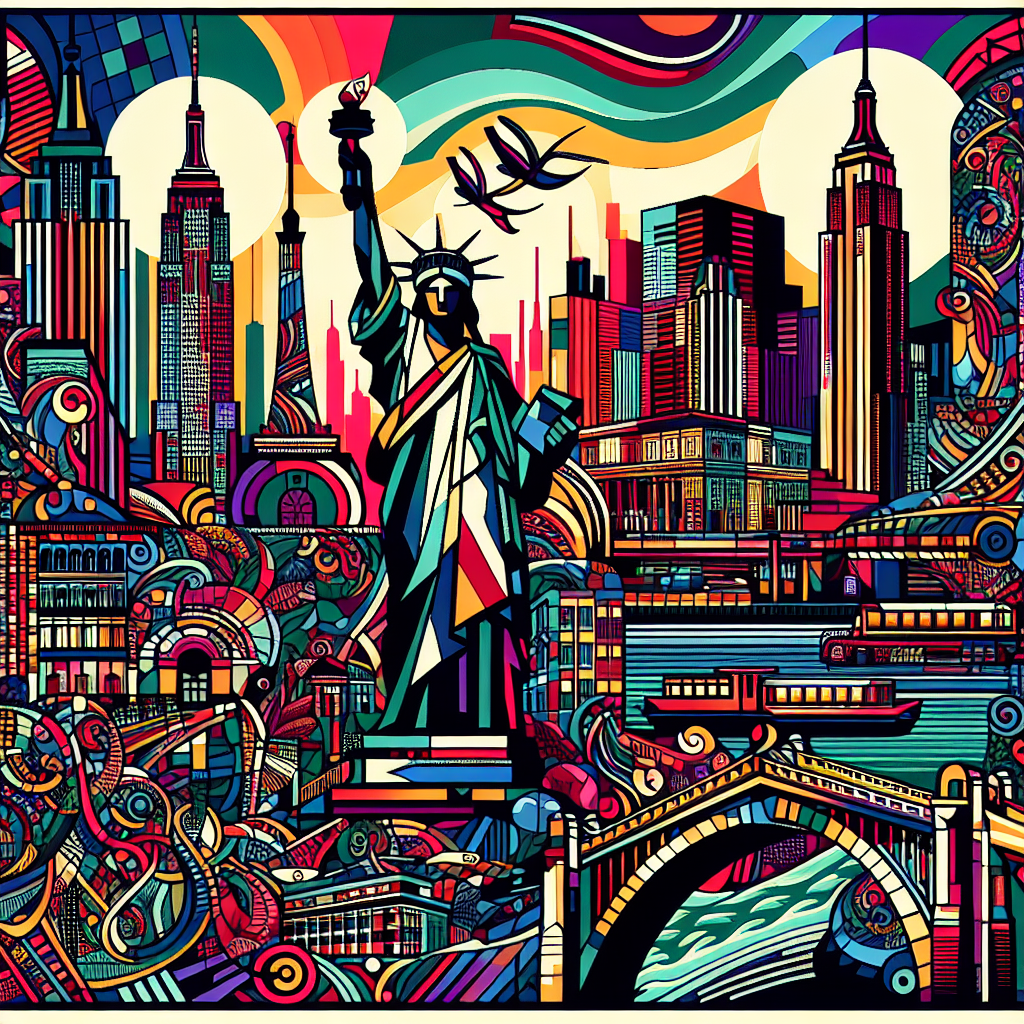

In [13]:
image = artist("New York City")
display(image)

## Audio 

NOTE: see day5 notebook for troubleshooting. 

And let's make a function that uses OpenAI's speech model to generate audio

In [14]:
# Verify ffmpeg installed and can access

!ffmpeg -version
!ffprobe -version
!ffplay -version

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-l

### Talker Function

NOTE: See day5 nb for troubleshooting permissions error writing to temp file

In [15]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # can also try alloy
        input=message
    )

    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [16]:
talker("Well, hi there")

Input #0, wav, from '/tmp/tmp17om5a2v.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:00.82, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

We're showing 1 and 2 here, and to a lesser extent 3 and 5. In week 8 we will do the lot!

## Chat Function

In [17]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    reply = response.choices[0].message.content
    history += [{"role": "assistant", "content": reply}]

    talker(reply)

    return history, image

## Gradio

In [19]:
# More involved Gradio code as we're not using the preset chat interface
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    
    def do_entry(message, history):
        history += [{"role": "user", "content": message}]
        return "", history
    
    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch()

* Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/tmp/tmpmsk9in6i.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.09, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Tool get_ticket_price called for New York City


Input #0, wav, from '/tmp/tmpgiqcrxrn.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:06.12, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
